In [74]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from time import time
import faiss
import numpy as np
import joblib
import libpysal
import pandas as pd
import h3
import json
import esda
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from libpysal import graph
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV

from shapely.geometry import Point
from shapely.geometry import Polygon, box

from PIL import Image

%matplotlib inline

In [99]:
# Step 1: Define the AOI for Soho, London
# This is an example bounding box around Soho, London. 
# You might want to refine this to a more accurate polygon as per your requirements.
soho_lon_min, soho_lat_min = -0.136, 51.512
soho_lon_max, soho_lat_max = -0.129, 51.516
soho_aoi = box(soho_lon_min, soho_lat_min, soho_lon_max, soho_lat_max)


In [100]:
# Step 1: Define the AOI for Coal Drops Yard, London
# Example coordinates for Coal Drops Yard; you might want to refine these for accuracy.
cdy_lon_min, cdy_lat_min = -0.1265, 51.5345
cdy_lon_max, cdy_lat_max = -0.1230, 51.5365
cdy_aoi = box(cdy_lon_min, cdy_lat_min, cdy_lon_max, cdy_lat_max)

# Step 2: (Assuming you have a GeoDataFrame `tiles_gdf` as before)


# Step 3: Query Overlapping Tiles
# Convert CDY AOI to a GeoSeries for spatial join
cdy_aoi_gseries = gpd.GeoSeries([cdy_aoi], crs="EPSG:4326")
cdy_aoi_gseries = cdy_aoi_gseries.to_crs('EPSG:27700')

In [101]:
# Perform spatial join to find overlapping tiles
overlapping_tiles = gpd.sjoin(tiles_gdf, gpd.GeoDataFrame(geometry=cdy_aoi_gseries), how="inner", op='intersects')

# Print IDs of overlapping tiles
print("Overlapping Tile IDs:", overlapping_tiles['filename'].tolist())

/rds/general/user/abm1818/home/anaconda3/envs/demoland_/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Overlapping Tile IDs: ['530391_183704.tif', '530284_183398.tif', '530071_183673.tif', '529964_183366.tif']


In [91]:
tiles_gdf = unmasked_gdf_all.to_crs('EPSG:27700')
tiles_gdf = tiles_gdf[['geometry', 'filename']]

# Step 3: Query Overlapping Tiles
# Convert Soho AOI to a GeoSeries to perform spatial join
soho_aoi_gseries = gpd.GeoSeries([soho_aoi], crs="EPSG:4326")
soho_aoi_gseries = soho_aoi_gseries.to_crs('EPSG:27700')

# Perform spatial join to find overlapping tiles
overlapping_tiles = gpd.sjoin(tiles_gdf, gpd.GeoDataFrame(geometry=soho_aoi_gseries), how="inner", op='intersects')

# Print IDs of overlapping tiles
print("Overlapping Tile IDs:", overlapping_tiles['filename'].tolist())

/rds/general/user/abm1818/home/anaconda3/envs/demoland_/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Overlapping Tile IDs: ['529426_180949.tif', '530065_181013.tif', '529533_181255.tif', '529853_181287.tif', '529745_180981.tif', '529958_180706.tif']


<Axes: >

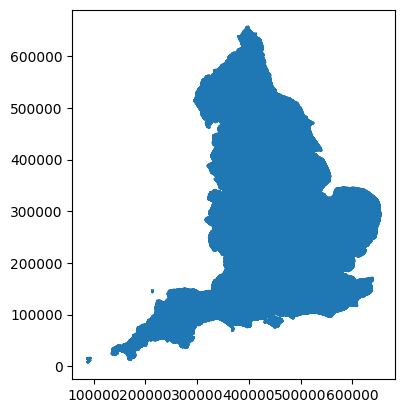

In [88]:
tiles_gdf.boundary.plot()

In [34]:
p = glob.glob('/rds/general/user/abm1818/projects/ssa_satellite_imagery/ephemeral/england/unmasked_fin/*.tif')
unm_df = pd.DataFrame(p, columns=['file'])

unm_df['filename'] = unm_df['file'].str.split('/').str[-1]
unm_df['x'] = unm_df['filename'].str.split('_').str[0]
unm_df['y'] = unm_df['filename'].str.split('_').str[1]
unm_df['y'] = unm_df['y'].str.replace('.tif', '')

unmask_emb = emb.copy()
unmask_emb['filename'] = unm_df['filename'].values

In [77]:
data = gpd.read_parquet(f"/rds/general/user/abm1818/projects/ssa_satellite_imagery/ephemeral/grid_complete.parquet")

geometry_un = [Point(xy) for xy in zip(unm_df['x'], unm_df['y'])]
gdf_unma = gpd.GeoDataFrame(unm_df, geometry=geometry_un)

gdf_unma.crs = 'epsg:27700'
joined_gdf_unma = gpd.sjoin(data, gdf_unma, how="left", op="contains")

joined_gdf_unma['hex_id'] = joined_gdf_unma.index
unmasked_gdf_all = pd.merge(joined_gdf_unma, unmask_emb, on='filename', how='right')


unmasked_gdf_all[['x', 'y']] = unmasked_gdf_all[['x', 'y']].astype(float)

/rds/general/user/abm1818/home/anaconda3/envs/demoland_/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


KeyError: "['Unnamed: 0'] not found in axis"

In [78]:
gdff = unmasked_gdf_all.columns.drop(['index_right', 'house_price_index', 'geometry',
 'file',
 'filename',
  'hex_id'])

In [38]:
im = unmask_emb[unmask_emb['filename'] == '387927_288144.tif']
im

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,filename
500000,3.328187,-8.139211,4.86618,1.402135,3.167159,1.60039,-5.155547,9.257653,-6.804381,-1.00023,...,3.111119,-4.889525,4.096954,-1.162643,3.97073,-0.217325,-9.947344,1.855497,-5.656113,387927_288144.tif


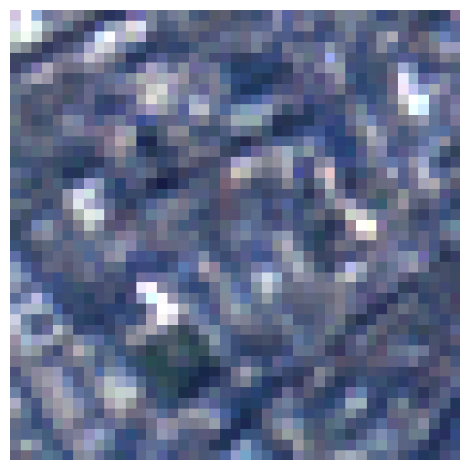

In [94]:
## SOHO
image = Image.open('/rds/general/user/abm1818/projects/ssa_satellite_imagery/ephemeral/england/unmasked_fin/529426_180949.tif')
image_array = np.array(image)  # Convert to NumPy array
plt.imshow(image_array)  # Plot image in subplot
plt.axis('off')  # Turn off axis numbers

plt.tight_layout()
plt.show()

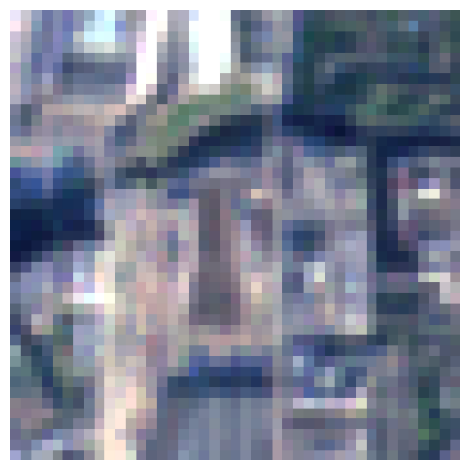

In [102]:
## CDY
image = Image.open('/rds/general/user/abm1818/projects/ssa_satellite_imagery/ephemeral/england/unmasked_fin/530284_183398.tif')
image_array = np.array(image)  # Convert to NumPy array
plt.imshow(image_array)  # Plot image in subplot
plt.axis('off')  # Turn off axis numbers

plt.tight_layout()
plt.show()

/rds/general/user/abm1818/projects/ssa_satellite_imagery/ephemeral/england/unmasked_fin/387927_288144.tif


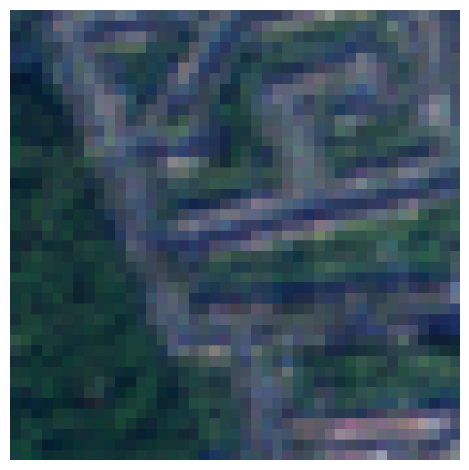

In [36]:
image = Image.open(str(p[500000+i]))
print(str(p[500000+i]))# Open each image
image_array = np.array(image)  # Convert to NumPy array
plt.imshow(image_array)  # Plot image in subplot
plt.axis('off')  # Turn off axis numbers

plt.tight_layout()
plt.show()

In [19]:
unmask_emb.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,filename
0,0,3.826133,-7.114394,3.498463,1.156586,2.921337,2.477534,-4.090148,8.613523,-6.859757,...,2.498440,-6.187055,1.807109,-1.033162,2.539761,-0.813491,-9.513372,1.315984,-4.973041,550262_164717.tif
1,1,1.594143,-7.648653,5.361984,1.390659,2.545120,1.882334,-6.640593,10.900363,-6.350642,...,3.870679,-5.343614,7.881583,-1.688463,5.399236,-0.085978,-11.713344,1.733743,-7.143404,415187_607967.tif
2,2,1.256206,-5.152084,2.077664,2.392908,0.996856,1.101623,-7.519114,9.640810,-4.612083,...,4.162684,-5.264299,5.837415,-0.689806,2.964180,-0.954282,-9.359049,0.872125,-6.696635,376448_308327.tif
3,3,3.710177,-7.484775,3.836276,0.351795,2.725268,2.314534,-1.963734,8.937081,-8.360998,...,1.222916,-4.025941,2.484271,-0.487501,2.537681,-1.667617,-8.583685,0.874696,-3.038139,506953_161826.tif
4,4,1.175816,-5.959046,5.100270,2.043205,1.732783,3.540869,-6.005545,11.290996,-5.392621,...,3.008194,-6.000693,8.150513,-0.749503,4.494267,-0.362102,-11.550441,-0.703511,-7.215008,345052_480973.tif


In [5]:
# Step 2: Prepare your data
# Assume embeddings is your dataset of 1,500,000 embeddings with 128 dimensions
#embeddings = np.random.rand(1500000, 128).astype('float32')
embeddings = pd.read_csv("/rds/general/user/abm1818/projects/ssa_satellite_imagery/ephemeral/england/embeddings_england_pool_nomask.csv")

In [7]:
emb= embeddings.iloc[:,1:]
emb.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,3.826133,-7.114394,3.498463,1.156586,2.921337,2.477534,-4.090148,8.613523,-6.859757,-1.989992,...,3.596936,2.498440,-6.187055,1.807109,-1.033162,2.539761,-0.813491,-9.513372,1.315984,-4.973041
1,1.594143,-7.648653,5.361984,1.390659,2.545120,1.882334,-6.640593,10.900363,-6.350642,-2.165333,...,1.744520,3.870679,-5.343614,7.881583,-1.688463,5.399236,-0.085978,-11.713344,1.733743,-7.143404
2,1.256206,-5.152084,2.077664,2.392908,0.996856,1.101623,-7.519114,9.640810,-4.612083,-1.132204,...,1.855684,4.162684,-5.264299,5.837415,-0.689806,2.964180,-0.954282,-9.359049,0.872125,-6.696635
3,3.710177,-7.484775,3.836276,0.351795,2.725268,2.314534,-1.963734,8.937081,-8.360998,-2.514874,...,3.267371,1.222916,-4.025941,2.484271,-0.487501,2.537681,-1.667617,-8.583685,0.874696,-3.038139
4,1.175816,-5.959046,5.100270,2.043205,1.732783,3.540869,-6.005545,11.290996,-5.392621,-2.575328,...,2.726964,3.008194,-6.000693,8.150513,-0.749503,4.494267,-0.362102,-11.550441,-0.703511,-7.215008


In [10]:
#query_embedding = np.random.rand(1, 128).astype('float32')  # Your query embedding
query_embedding = emb.iloc[100:101,:]
query_embedding

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
100,2.63281,-6.044729,3.449338,2.017508,2.60895,1.400994,-6.041555,9.921985,-6.608323,-1.560467,...,2.76,3.603559,-5.575114,5.904943,-0.724524,4.516109,-0.604018,-10.56973,0.638655,-6.061384


In [71]:
image = im.iloc[:,:-1]
image

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
500000,3.328187,-8.139211,4.86618,1.402135,3.167159,1.60039,-5.155547,9.257653,-6.804381,-1.00023,...,2.534952,3.111119,-4.889525,4.096954,-1.162643,3.97073,-0.217325,-9.947344,1.855497,-5.656113


In [103]:
im = unmask_emb[unmask_emb['filename'] == '530284_183398.tif']
image = im.iloc[:,:-1]
image

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
709580,2.371387,-8.764327,4.278881,0.955118,2.966101,2.510081,-2.777337,9.085672,-7.162378,-0.850266,...,3.25986,1.769043,-4.300563,3.01684,-0.487339,2.754163,-0.443609,-8.585681,1.484357,-4.271867


In [104]:
# Step 3: Create a FAISS index
index = faiss.IndexFlatL2(128)  # Using L2 distance for finding nearest neighbors

# Step 4: Add embeddings to the index
index.add(emb)

# Perform the search for the 10 closest neighbors
k = 20  # Number of nearest neighbors to find
D, I = index.search(image, k)  # D is the distance, I is the index of the nearest neighbors

# D contains the distances to the k-nearest neighbors
# I contains the indices of the k-nearest neighbors
for i in range(k):
    print(f"Neighbor {i+1}: Index - {I[0][i]}, Distance - {D[0][i]}")

Neighbor 1: Index - 709580, Distance - 0.0
Neighbor 2: Index - 1100045, Distance - 19.45135498046875
Neighbor 3: Index - 1283700, Distance - 20.188316345214844
Neighbor 4: Index - 941952, Distance - 20.519514083862305
Neighbor 5: Index - 1070678, Distance - 21.068599700927734
Neighbor 6: Index - 1242911, Distance - 21.390003204345703
Neighbor 7: Index - 876519, Distance - 21.69979476928711
Neighbor 8: Index - 300998, Distance - 21.90135955810547
Neighbor 9: Index - 226833, Distance - 22.40209197998047
Neighbor 10: Index - 232607, Distance - 22.716081619262695
Neighbor 11: Index - 1191873, Distance - 23.178611755371094
Neighbor 12: Index - 1220591, Distance - 23.392017364501953
Neighbor 13: Index - 811068, Distance - 23.455894470214844
Neighbor 14: Index - 1029508, Distance - 23.520395278930664
Neighbor 15: Index - 675224, Distance - 23.76854133605957
Neighbor 16: Index - 1045484, Distance - 24.367725372314453
Neighbor 17: Index - 815169, Distance - 24.63823699951172
Neighbor 18: Index 

In [67]:
unmask_emb.iloc[500000:500000+1]['filename'].values[0]

'387927_288144.tif'

In [58]:
im = unmask_emb[unmask_emb['filename'] == '387927_288144.tif']
im

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,filename
500000,3.328187,-8.139211,4.86618,1.402135,3.167159,1.60039,-5.155547,9.257653,-6.804381,-1.00023,...,3.111119,-4.889525,4.096954,-1.162643,3.97073,-0.217325,-9.947344,1.855497,-5.656113,387927_288144.tif


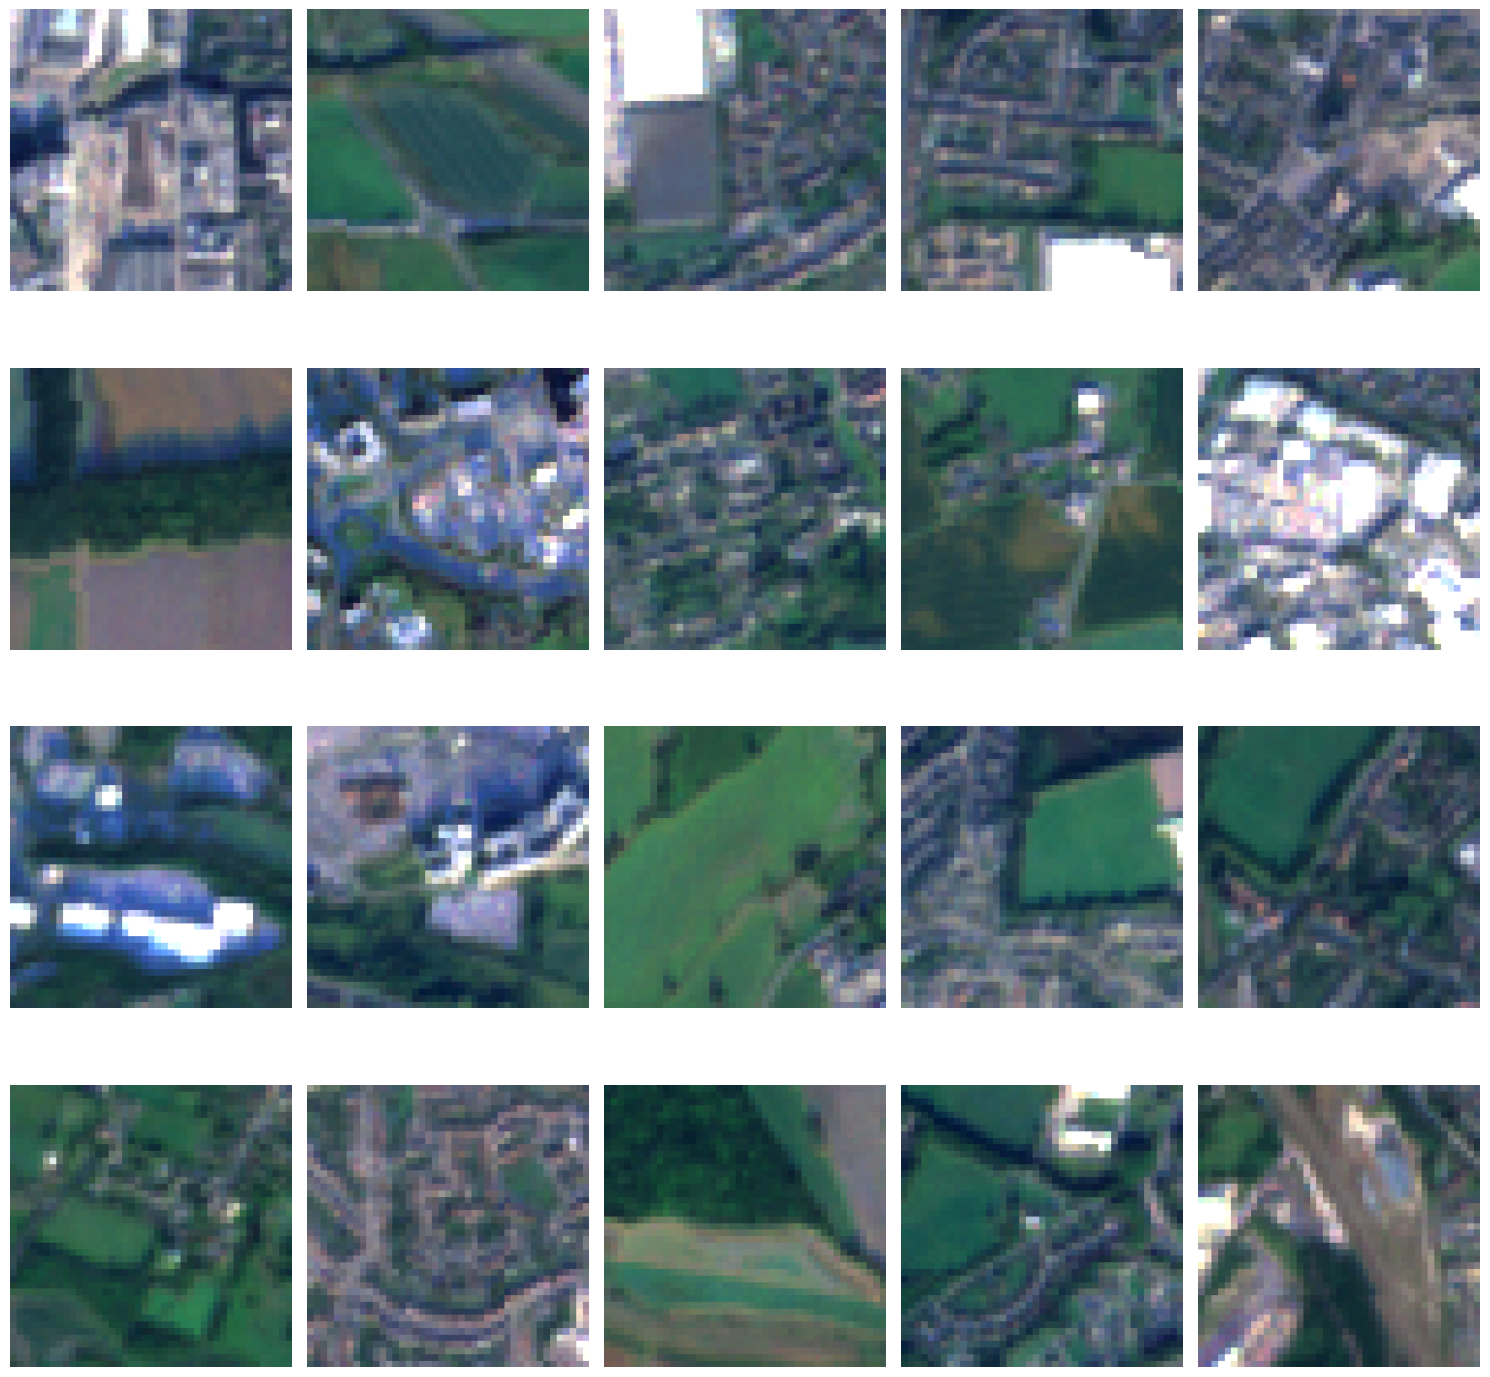

In [107]:
#CDY
folder = '/rds/general/user/abm1818/projects/ssa_satellite_imagery/ephemeral/england/unmasked_fin/'
fig, axs = plt.subplots(4, 5, figsize=(15, 15)) # 5x5 grid of plots
axs = axs.ravel() # Flatten the 2D array of axes for easy indexing

for i in I:
    for ind, j in enumerate(i):
        #print(j)
        image = Image.open(folder + str(unmask_emb.iloc[j:j+1]['filename'].values[0]))
        #print(folder + str(unmask_emb.iloc[j:j+1]['filename'].values[0]))# Open each image
        image_array = np.array(image)  # Convert to NumPy array
        axs[ind].imshow(image_array)  # Plot image in subplot
        axs[ind].axis('off')  # Turn off axis numbers

plt.tight_layout()
plt.show()

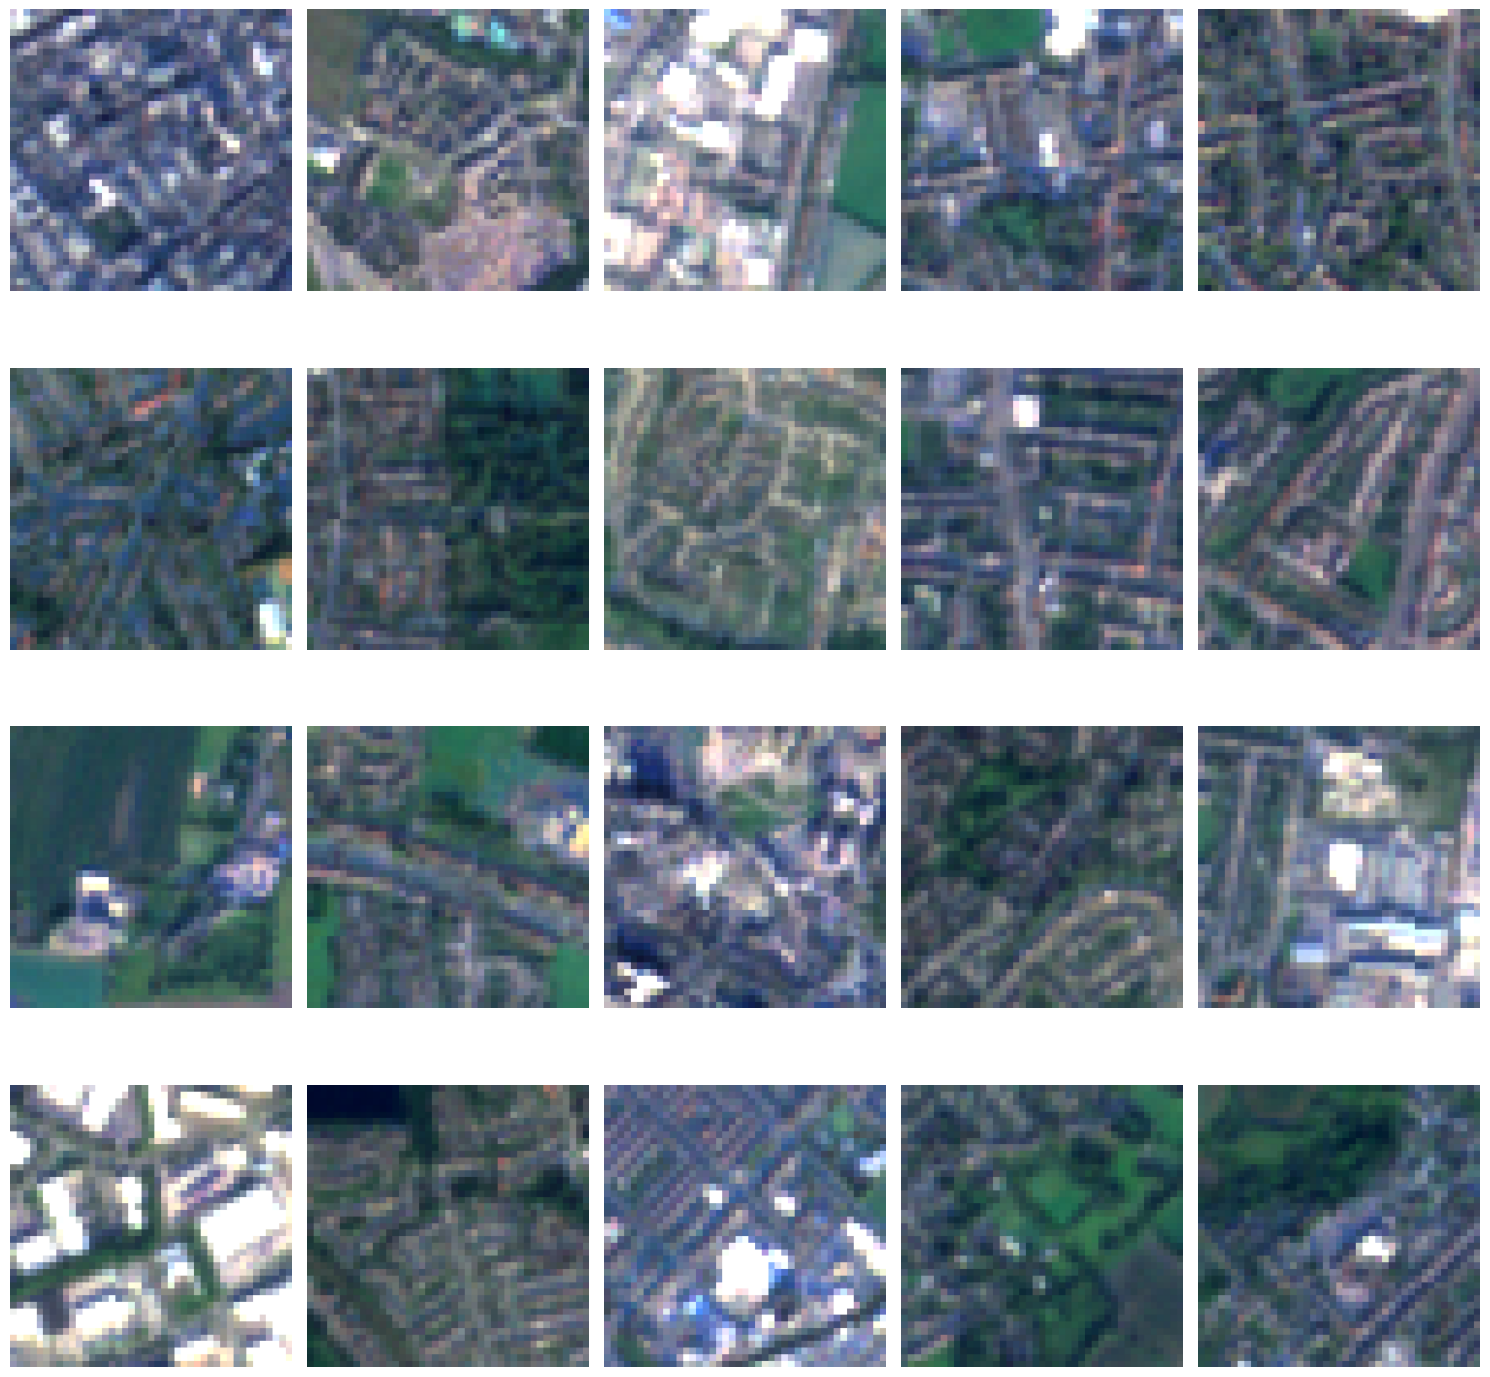

In [98]:
folder = '/rds/general/user/abm1818/projects/ssa_satellite_imagery/ephemeral/england/unmasked_fin/'
fig, axs = plt.subplots(4, 5, figsize=(15, 15)) # 5x5 grid of plots
axs = axs.ravel() # Flatten the 2D array of axes for easy indexing

for i in I:
    for ind, j in enumerate(i):
        #print(j)
        image = Image.open(folder + str(unmask_emb.iloc[j:j+1]['filename'].values[0]))
        #print(folder + str(unmask_emb.iloc[j:j+1]['filename'].values[0]))# Open each image
        image_array = np.array(image)  # Convert to NumPy array
        axs[ind].imshow(image_array)  # Plot image in subplot
        axs[ind].axis('off')  # Turn off axis numbers

plt.tight_layout()
plt.show()

In [16]:
I

array([[   100, 950671]])